In [1]:

!pip install sqlalchemy
!pip install psycopg2
!pip install psycopg2-binary

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import math
from statsmodels.tools.eval_measures import mse, rmse
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
color = sns.color_palette()
sns.set_style('darkgrid')
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV




# import warnings
warnings.filterwarnings('ignore')

In [0]:
# Database credentials
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

# use the credentials to start a connection
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df= pd.read_sql_query('select * from houseprices', con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

In [4]:
#explore the dataset
df

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,...,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,...,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,1999.0,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,None,None,None,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,...,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,1978.0,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,None,MnPrv,None,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,...,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,1941.0,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,None,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,6,1950,1996,Hip,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

In [6]:
#checking for null values
df.isnull().sum()

id                 0
mssubclass         0
mszoning           0
lotfrontage      259
lotarea            0
                ... 
mosold             0
yrsold             0
saletype           0
salecondition      0
saleprice          0
Length: 81, dtype: int64

In [12]:
#describe the data
df.describe()


,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,totrmsabvgrd,fireplaces,garageyrblt,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [0]:
# differentiating numeric and non-numeric columns

In [9]:
#non_ numerical comumns
non_numeric_columns=df.select_dtypes(["object"]).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 43


numeric_columns=df.select_dtypes(["int64","float64"]).columns
print(numeric_columns)

In [8]:
numeric_columns=df.select_dtypes(["int64","float64"]).columns
print(numeric_columns)
print("The number of numeric columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numeric columns is 38


Dealing with missing values

In [13]:
total_of_missing=df.isnull().sum().sort_values(ascending=False)
percent_of_missing=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_info=pd.concat([total_of_missing,percent_of_missing], axis=1, keys=['Total', 'Percent'])
missing_info.head(30)


,Total,Percent
lotfrontage,259,0.177397
garagefinish,81,0.055479
garagetype,81,0.055479
garagecond,81,0.055479
garagequal,81,0.055479
garageyrblt,81,0.055479
bsmtexposure,38,0.026027
bsmtfintype2,38,0.026027
bsmtfintype1,37,0.025342
bsmtcond,37,0.025342


I will go ahead and delete the feature with a high percentage of null values (40% or greater)

In [0]:
df=df.drop(["poolqc","miscfeature","alley","fence","fireplacequ"], axis=1)

In [0]:
#Exploratory Data Analysis. Looking at the larget variable

In [15]:
# new list of non_numeric columns after removing those with high null values
non_numeric_columns=df.select_dtypes(["object"]).columns
print(non_numeric_columns)
print("The number of non-numeric columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'garagetype', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'saletype', 'salecondition'],
      dtype='object')
The number of non-numeric columns is 38


In [0]:
#I will remove some columns that may not help in predicting houseprice

In [0]:
df=df.drop(["bsmtfinsf2","lowqualfinsf","kitchenabvgr","enclosedporch","threessnporch","screenporch","poolarea","miscval","yearbuilt","yearremodadd","garageyrblt", "enclosedporch"], axis=1)

In [17]:
# new list of numeric columns after removing those with high null values
numeric_columns=df.select_dtypes(["int64","float64"]).columns
print(numeric_columns)
print("The number of numeric columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'masvnrarea', 'bsmtfinsf1', 'bsmtunfsf', 'totalbsmtsf',
       'firstflrsf', 'secondflrsf', 'grlivarea', 'bsmtfullbath',
       'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr', 'totrmsabvgrd',
       'fireplaces', 'garagecars', 'garagearea', 'wooddecksf', 'openporchsf',
       'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numeric columns is 27


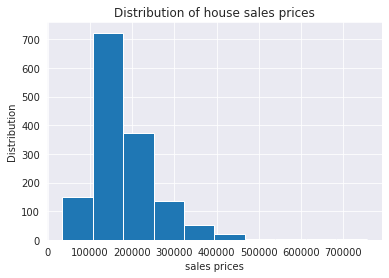

In [18]:
#Checking the distribution of the target variable
plt.hist(df.saleprice)
plt.title("Distribution of house sales prices")
plt.xlabel("sales prices")
plt.ylabel("Distribution")
plt.show()

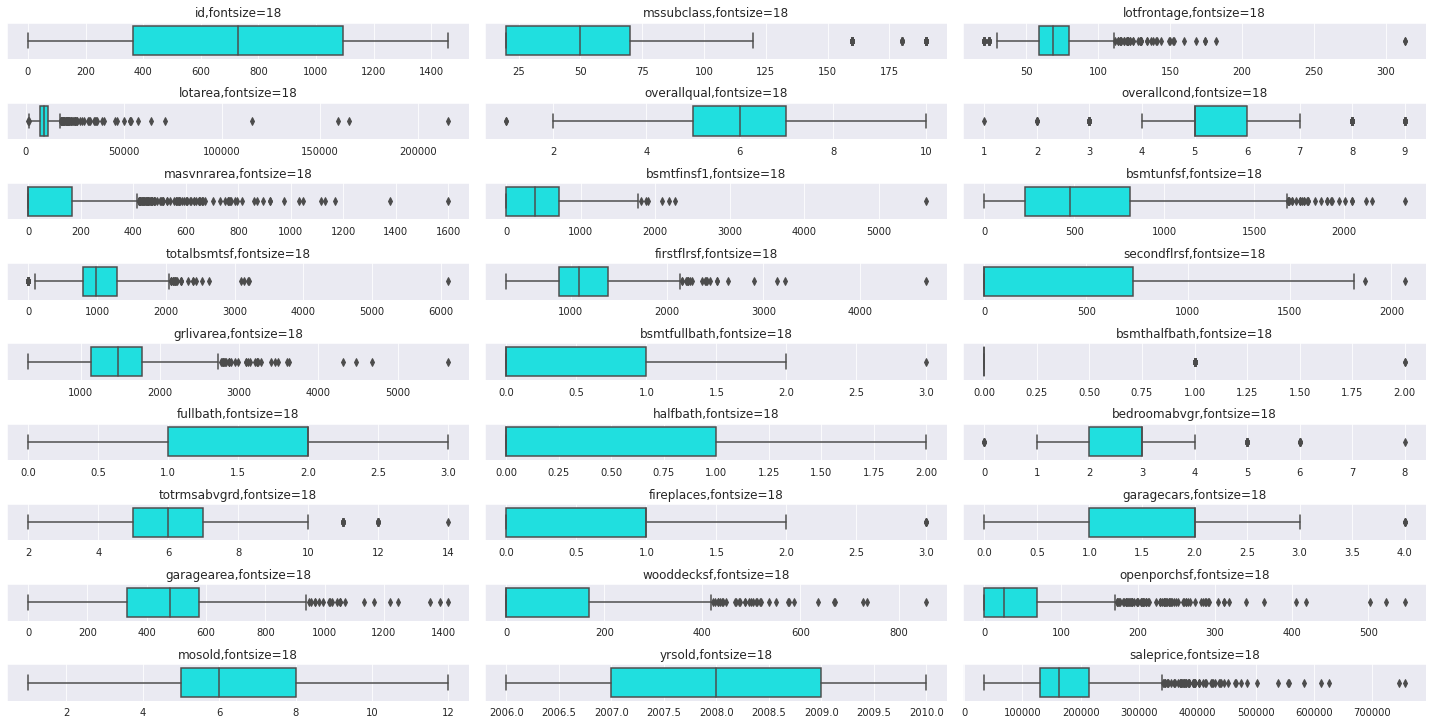

In [19]:
#Dealing with outliers
#Detecting otliers.
#We draw the boxplot to detect outliers
plt.figure(figsize=(20,30))
for i, col in enumerate(numeric_columns):
  plt.subplot(len(numeric_columns), 3, i+1)
  sns.boxplot(df[col], color=('cyan'))
  plt.title(f'{col},fontsize=18')
  plt.xlabel('')

plt.tight_layout()
plt.show()

In [0]:
#Apply winsorizing to remove outliers
df['mssubclass']=winsorize(df['mssubclass'],(0.0,0.1))
df['lotfrontage']=winsorize(df['lotfrontage'],(0.05,0.2))
df['lotarea']=winsorize(df['lotarea'],(0.05,0.15))
df['overallqual']=winsorize(df['overallqual'],(0.05,0.0))
df['overallcond']=winsorize(df['overallcond'],(0.05,0.05))
df['masvnrarea']=winsorize(df['masvnrarea'],(0.0,0.15))
df['bsmtfinsf1']=winsorize(df['bsmtfinsf1'],(0.0,0.05))
df['bsmtunfsf']=winsorize(df['bsmtunfsf'],(0.0,0.15))
df['totalbsmtsf']=winsorize(df['totalbsmtsf'],(0.05,0.10))
df['firstflrsf']=winsorize(df['firstflrsf'],(0.0,0.10))
df['secondflrsf']=winsorize(df['secondflrsf'],(0.0,0.05))
df['lotfrontage']=winsorize(df['lotfrontage'],(0.05,0.15))
df['grlivarea']=winsorize(df['grlivarea'],(0.0,0.15))
df['bsmthalfbath']=winsorize(df['bsmthalfbath'],(0,0.05))
df['bsmtfullbath']=winsorize(df['bsmtfullbath'],(0.0,0.05))
df['bedroomabvgr']=winsorize(df['bedroomabvgr'],(0.05,0.10))
df['totrmsabvgrd']=winsorize(df['totrmsabvgrd'],(0.0,0.05))
df['fireplaces']=winsorize(df['fireplaces'],(0.0,0.05))
df['garagecars']=winsorize(df['garagecars'],(0.0,0.05))
df['garagearea']=winsorize(df['garagearea'],(0.0,0.15))
df['wooddecksf']=winsorize(df['wooddecksf'],(0.0,0.15))
df['openporchsf']=winsorize(df['openporchsf'],(0.0,0.2))
df['saleprice']=winsorize(df['saleprice'],(0.0,0.15))


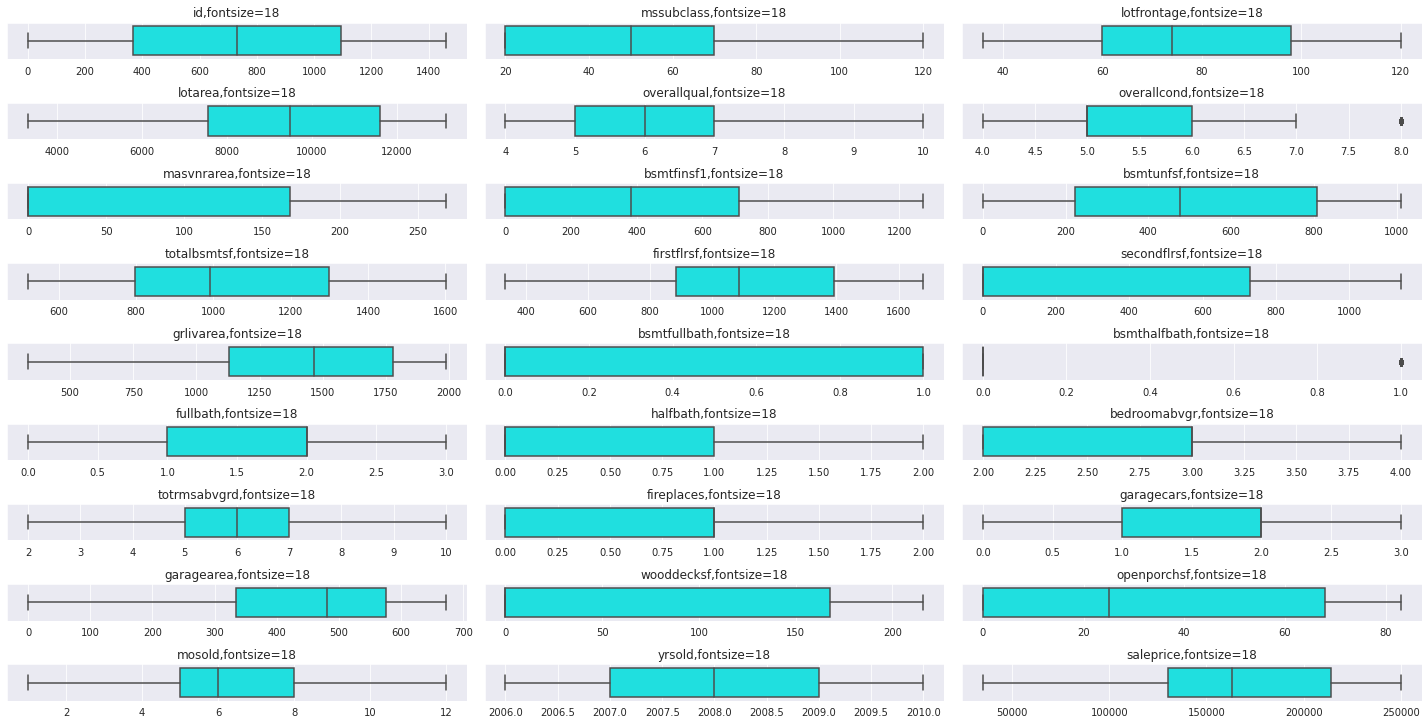

In [21]:
#check for outliers again after wisorizing
#We draw the boxplot to detect outliers
plt.figure(figsize=(20,30))
for i, col in enumerate(numeric_columns):
  plt.subplot(len(numeric_columns), 3, i+1)
  sns.boxplot(df[col], color=('cyan'))
  plt.title(f'{col},fontsize=18')
  plt.xlabel('')

plt.tight_layout()
plt.show()

In [22]:
#now visualize the data
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,150,856,GasA,Ex,Y,SBrkr,856,854,1710,1,0,2,1,3,Gd,8,Typ,0,Attchd,RFn,2,548,TA,TA,Y,0,61,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,284,1262,GasA,Ex,Y,SBrkr,1262,0,1262,0,1,2,0,3,TA,6,Typ,1,Attchd,RFn,2,460,TA,TA,Y,216,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,434,920,GasA,Ex,Y,SBrkr,920,866,1786,1,0,2,1,3,Gd,6,Typ,1,Attchd,RFn,2,608,TA,TA,Y,0,42,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,540,756,GasA,Gd,Y,SBrkr,961,756,1717,1,0,1,0,3,Gd,7,Typ,1,Detchd,Unf,3,642,TA,TA,Y,0,35,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,13159,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,268.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,490,1145,GasA,Ex,Y,SBrkr,1145,1053,1987,1,0,2,1,4,Gd,9,Typ,1,Attchd,RFn,3,672,TA,TA,Y,192,83,12,2008,WD,Normal,250000


In [0]:
#correlation matrix

In [24]:
print(df.corr())

                    id  mssubclass  lotfrontage  ...    mosold    yrsold  saleprice
id            1.000000    0.017370    -0.005863  ...  0.021172  0.000712  -0.019312
mssubclass    0.017370    1.000000    -0.236987  ...  0.007869 -0.021740  -0.016032
lotfrontage  -0.005863   -0.236987     1.000000  ... -0.004164  0.020499   0.284044
lotarea      -0.012285   -0.415987     0.496054  ...  0.006731 -0.021229   0.435353
overallqual  -0.028071    0.083700     0.140820  ...  0.065452 -0.026024   0.799461
overallcond   0.006217   -0.089614    -0.031922  ... -0.004634  0.051191  -0.106199
masvnrarea   -0.038924    0.028957     0.168880  ...  0.022677  0.002301   0.407210
bsmtfinsf1   -0.011902   -0.070282     0.163766  ... -0.005182  0.014910   0.333886
bsmtunfsf    -0.007693   -0.113852    -0.004800  ...  0.033654 -0.041236   0.176356
totalbsmtsf  -0.030228   -0.245326     0.224898  ...  0.035539 -0.012361   0.622956
firstflrsf    0.001986   -0.230857     0.265795  ...  0.056177 -0.013786   0

In [0]:
# relationship between sale price and other variables
#finding the features that are most closely related to salesprice
#this only applies to numeric columns

In [26]:
np.abs(df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice       1.000000
overallqual     0.799461
grlivarea       0.731817
garagecars      0.675006
garagearea      0.640496
totalbsmtsf     0.622956
fullbath        0.611695
firstflrsf      0.590834
totrmsabvgrd    0.524239
fireplaces      0.489194
openporchsf     0.468174
lotarea         0.435353
masvnrarea      0.407210
wooddecksf      0.358069
bsmtfinsf1      0.333886
halfbath        0.314266
secondflrsf     0.308961
lotfrontage     0.284044
bedroomabvgr    0.245427
bsmtfullbath    0.223445
bsmtunfsf       0.176356
overallcond     0.106199
mosold          0.069496
yrsold          0.034337
bsmthalfbath    0.018449
mssubclass      0.016032
Name: saleprice, dtype: float64

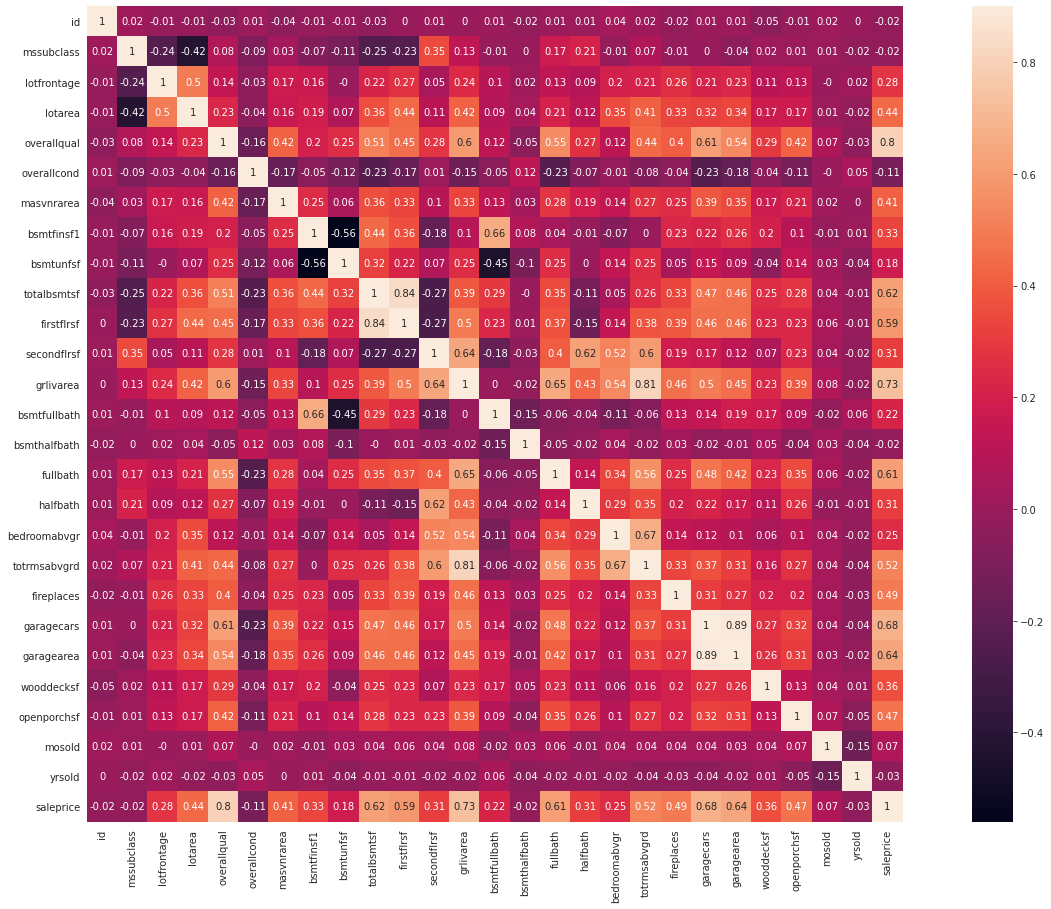

In [27]:
data=df[numeric_columns]
plt.figure(figsize=(25,15))
corrmat=data.corr().round(2)
sns.heatmap(corrmat, vmax=0.9, square=True, annot=True)

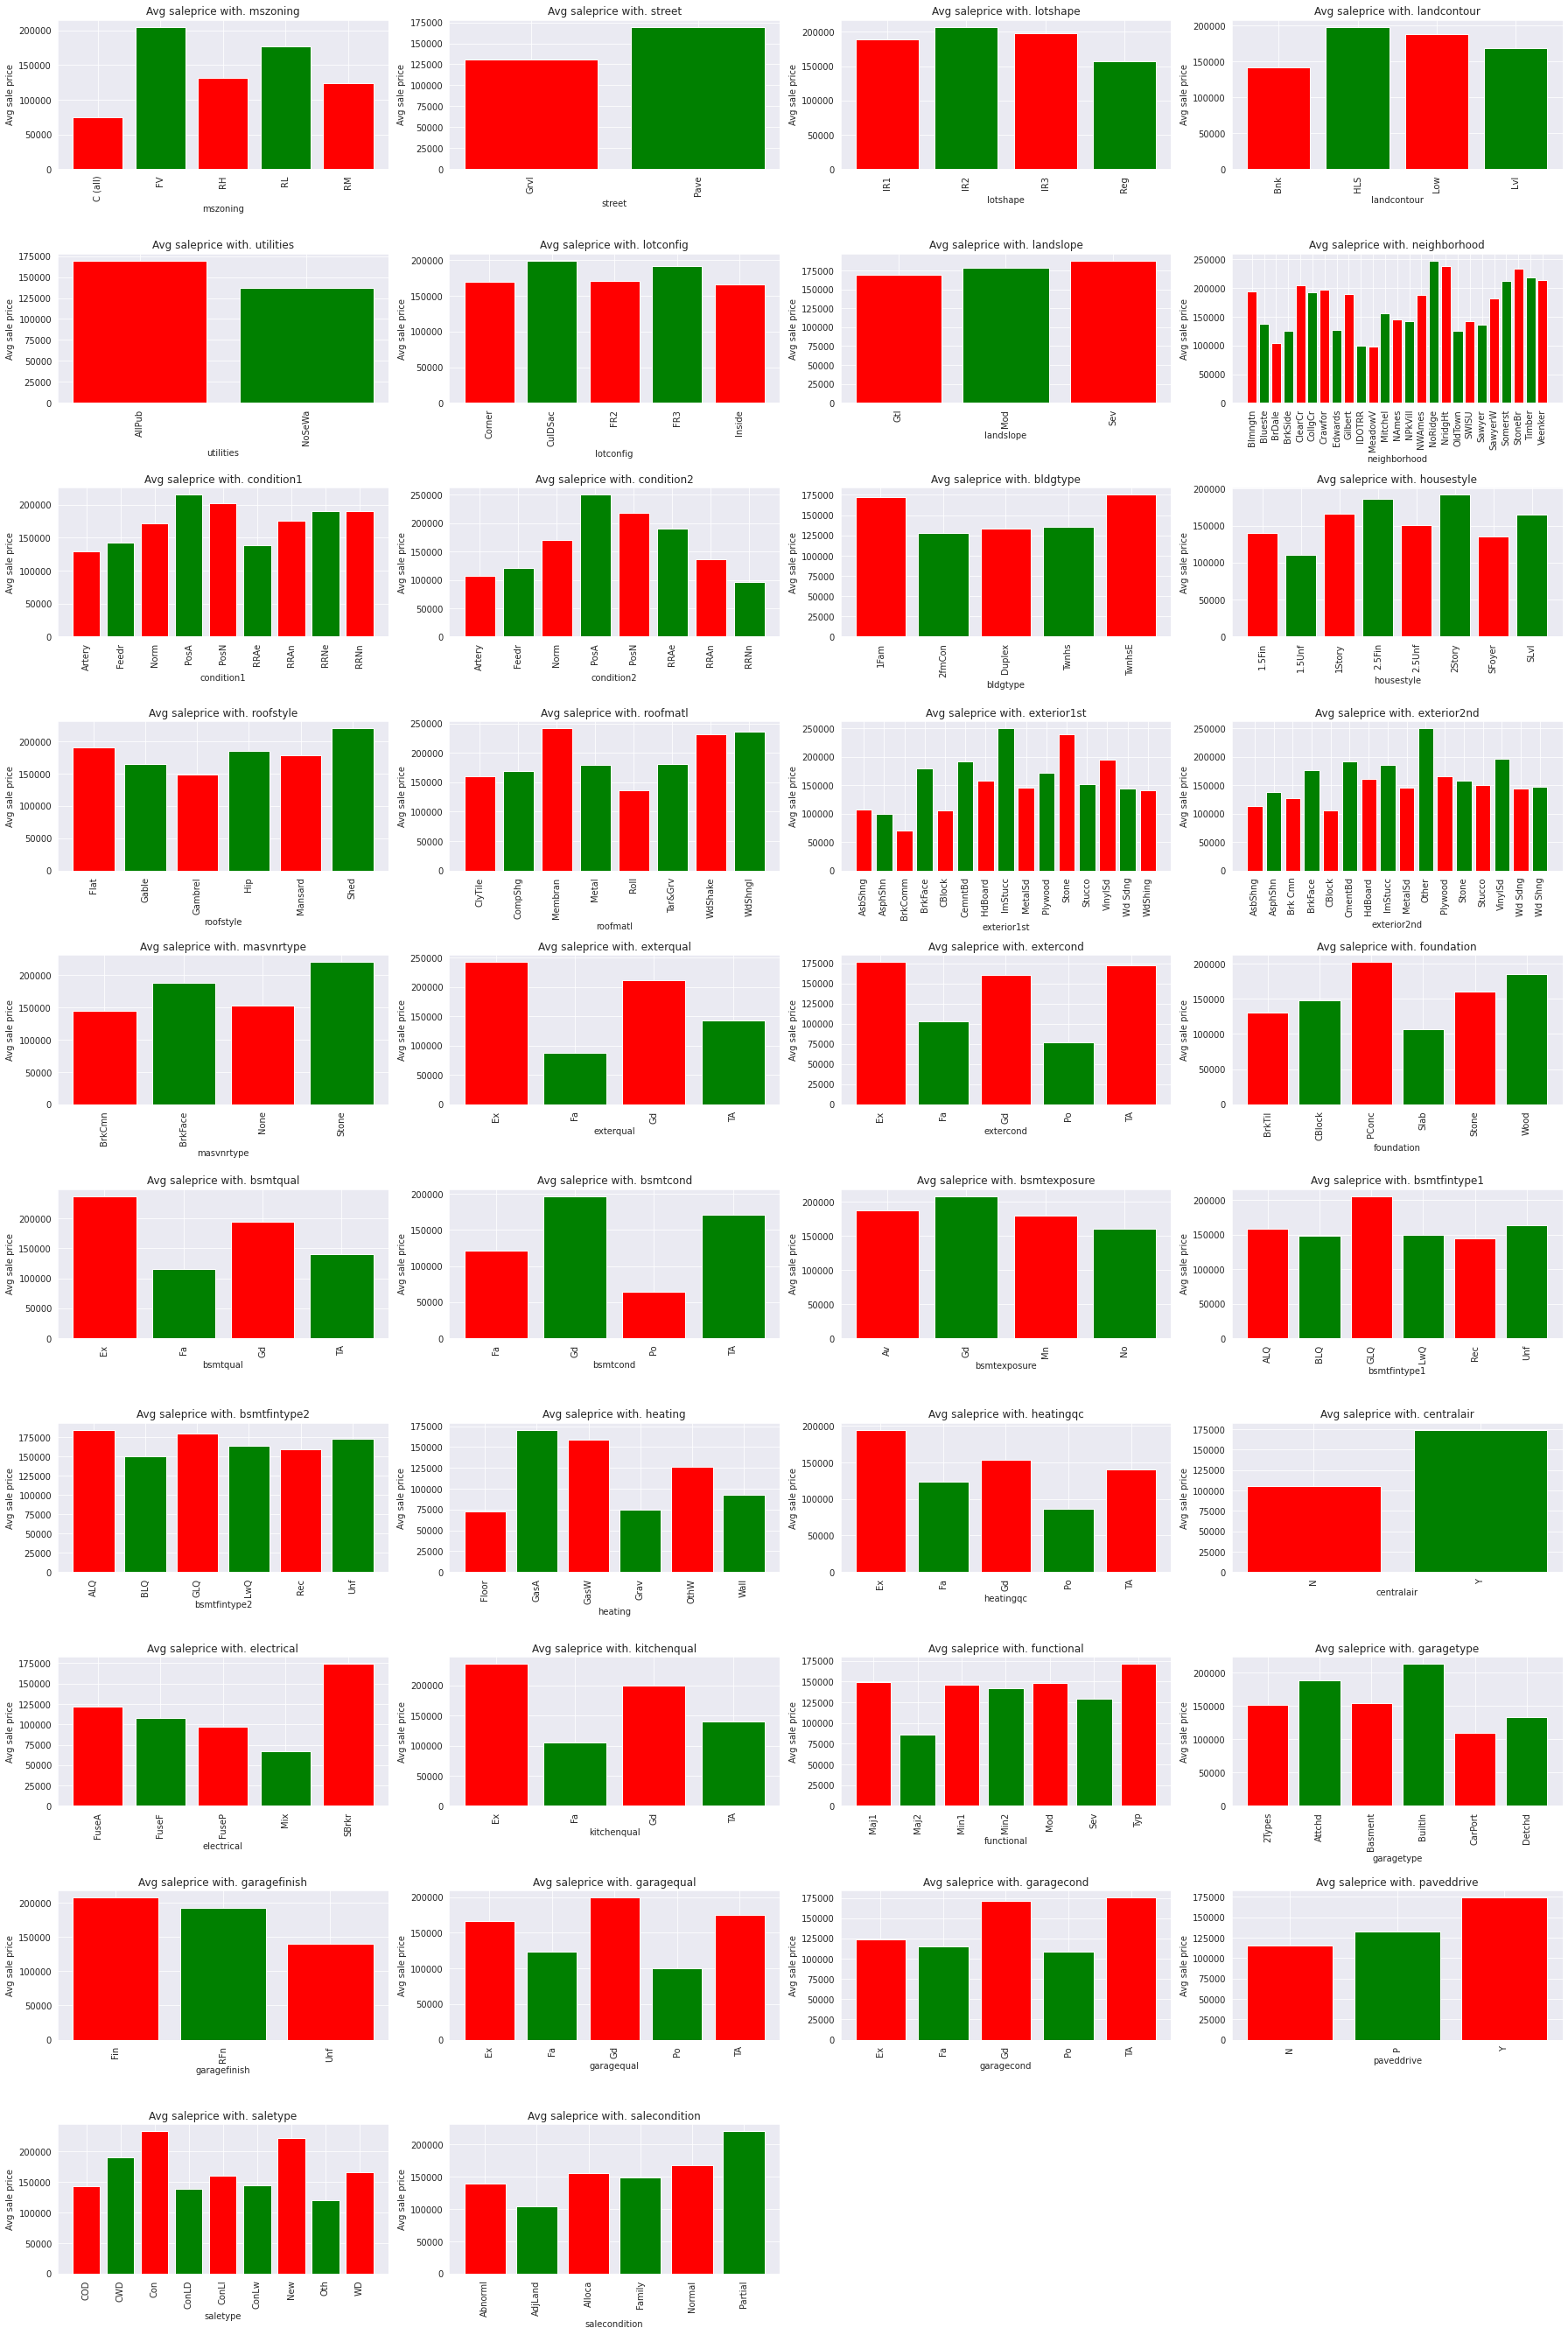

In [28]:
#plot each feature against the varable for univariate analysis
plt.figure(figsize=(25,40))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4, index+1)
    plt.bar(df.groupby(column)["saleprice"].mean().index, df.groupby(column)["saleprice"].mean(),
            color=("red","green"))
    plt.title("Avg saleprice with. {}".format(column))
    plt.ylabel("Avg sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

In [0]:
# non_numeric features Chosen: mszoning and street
#numeric features chosen:overallqual, grlivarea ,garagecars,garagearea, totalbsmtsf


Regression Model

In [0]:
#features to use
df=pd.concat([df,pd.get_dummies(df.mszoning,prefix="mszoning",drop_first=True)], axis=1)
df=pd.concat([df,pd.get_dummies(df.street,prefix="street",drop_first=True)], axis=1)
dummy_column_names=list(pd.get_dummies(df.mszoning,prefix="mszoning",drop_first=True).columns)
dummy_column_names=dummy_column_names + list(pd.get_dummies(df.street,prefix="street",drop_first=True).columns)

In [30]:
df["yrsold"].describe()

count    1460.000000
mean     2007.815753
std         1.328095
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: yrsold, dtype: float64

In [0]:
#explanatory variables and target variables
#We normalized the target variable since we determined that the data was slightly skewed
df["total_sf"]=df['firstflrsf'] + df['secondflrsf'] + df['totalbsmtsf']

df['int_over_sf']=df['total_sf'] *df['overallqual']


X = df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'total_sf', 'int_over_sf'] + dummy_column_names]
Y=np.log1p(df["saleprice"])


In [0]:
#df["mszoning_FV"].nunique()

In [0]:
#split the data
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2, random_state=465)

alphas=[np.power(10.0,p) for p in np.arange(-10,40,1)]

In [34]:
#Using linear regression without the regularization
#LinearRegression.fit(X_train, y_train)

#y_preds_train=LinearRegression.predict(X_train)
#y_preds_test=LinearRegression.predict(X_test)
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import RepeatedKFold


lrm = LinearRegression()

lrm.fit(X_train, y_train)
linear_reg_cv= cross_val_score(lrm, X, Y, cv=5)

# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8195508566349227
-----Test set statistics-----
R-squared of the model in the test set is: 0.8063363961291282
Mean absolute error of the prediction is: 0.11257910155069502
Mean squared error of the prediction is: 0.02356808887755482
Root mean squared error of the prediction is: 0.15351901796700895
Mean absolute percentage error of the prediction is: 0.9504105516308927


In [35]:
linear_reg_cv

array([0.84160689, 0.81906826, 0.78776758, 0.82313841, 0.79130681])

In [36]:
linear_reg_cv.mean()

0.8125775916889367

In [37]:
#Ridge regression

ridge_cv=RidgeCV(alphas=alphas, cv=5)

ridge_cv.fit(X_train, y_train)

y_preds_train = ridge_cv.predict(X_train)
y_preds_test = ridge_cv.predict(X_test)

#predicting


print("Best alpha value is: {}".format(ridge_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(ridge_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridge_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


Best alpha value is: 1.0
R-squared of the model on the training set is: 0.8184791394050326
-----Test set statistics-----
R-squared of the model on the test set is: 0.799993866414519
Mean absolute error of the prediction is: 0.11367587301858494
Mean squared error of the prediction is: 0.024339949470018617
Root mean squared error of the prediction is: 0.15601265804420683
Mean absolute percentage error of the prediction is: 0.9603286815323889


In [38]:
#Lasso regression
lasso_cv=LassoCV(alphas=alphas, cv=5)

lasso_cv.fit(X_train, y_train)

y_preds_train = lasso_cv.predict(X_train)
y_preds_test = lasso_cv.predict(X_test)

#predicting


print("Best alpha value is: {}".format(lasso_cv.alpha_))
print("R-squared of the model on the training set is: {}".format(lasso_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lasso_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

Best alpha value is: 0.0001
R-squared of the model on the training set is: 0.8192794123028028
-----Test set statistics-----
R-squared of the model on the test set is: 0.8039024215364007
Mean absolute error of the prediction is: 0.11303053950777624
Mean squared error of the prediction is: 0.023864293886552604
Root mean squared error of the prediction is: 0.15448072334939594
Mean absolute percentage error of the prediction is: 0.9545079653559907


In [39]:
#ElasticNet regression
from sklearn.linear_model import ElasticNet

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5) 
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8194341666077737
-----Test set statistics-----
R-squared of the model on the test set is: 0.8046733475915508
Mean absolute error of the prediction is: 0.11289463205108984
Mean squared error of the prediction is: 0.02377047525763813
Root mean squared error of the prediction is: 0.1541767662705316
Mean absolute percentage error of the prediction is: 0.9532704940669878


# Analysis:
Based on the results from the 3 models performance on the training and test set, the linear regression model regression model seems to perform better than the rest. 


In [0]:
ratedf=pd.read_csv("https://raw.githubusercontent.com/ssembahen/saved_files/master/federal_rate.csv")

To add an external factor which is not in the data to improve performance, I chose interest rate. Below I am importing the external data

In [41]:
ratedf.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [42]:
ratedf.isnull().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

In [43]:
ratedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 904 entries, 0 to 903
Data columns (total 10 columns):
Year                            904 non-null int64
Month                           904 non-null int64
Day                             904 non-null int64
Federal Funds Target Rate       462 non-null float64
Federal Funds Upper Target      103 non-null float64
Federal Funds Lower Target      103 non-null float64
Effective Federal Funds Rate    752 non-null float64
Real GDP (Percent Change)       250 non-null float64
Unemployment Rate               752 non-null float64
Inflation Rate                  710 non-null float64
dtypes: float64(7), int64(3)
memory usage: 70.8 KB


In [0]:
ratedf.columns = ratedf.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

In [0]:
ratedf['date'] = pd.to_datetime(ratedf.year*10000+ratedf.month*100+ratedf.day,format='%Y%m%d')
ratedf2 =ratedf.copy()
ratedf2.set_index('date',inplace=True)

In [0]:
variables = ratedf2.loc[:,['year','effective_federal_funds_rate','unemployment_rate']]
byyear = variables.groupby('year')
economicfeatures= byyear.mean()
economicfeatures['yrsold'] = economicfeatures.index

In [47]:
variables.describe()

,year,effective_federal_funds_rate,unemployment_rate
count,904.000000,752.000000,752.000000
mean,1986.680310,4.910997,5.979122
std,17.172843,3.611431,1.567641
min,1954.000000,0.070000,3.400000
25%,1973.000000,2.427500,4.900000
50%,1987.500000,4.700000,5.700000
75%,2001.000000,6.580000,7.000000
max,2017.000000,19.100000,10.800000


In [48]:
df2 = pd.merge(df, economicfeatures)
df2

,id,mssubclass,mszoning,lotfrontage,lotarea,street,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,garagetype,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,mosold,yrsold,saletype,salecondition,saleprice,mszoning_FV,mszoning_RH,mszoning_RL,mszoning_RM,street_Pave,total_sf,int_over_sf,effective_federal_funds_rate,unemployment_rate
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,150,856,GasA,Ex,Y,SBrkr,856,854,1710,1,0,2,1,3,Gd,8,Typ,0,Attchd,RFn,2,548,TA,TA,Y,0,61,2,2008,WD,Normal,208500,0,0,1,0,1,2566,17962,1.9275,5.800000
1,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,434,920,GasA,Ex,Y,SBrkr,920,866,1786,1,0,2,1,3,Gd,6,Typ,1,Attchd,RFn,2,608,TA,TA,Y,0,42,9,2008,WD,Normal,223500,0,0,1,0,1,2706,18942,1.9275,5.800000
2,5,60,RL,84.0,13159,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,268.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,490,1145,GasA,Ex,Y,SBrkr,1145,1053,1987,1,0,2,1,4,Gd,9,Typ,1,Attchd,RFn,3,672,TA,TA,Y,192,83,12,2008,WD,Normal,250000,0,0,1,0,1,3343,26744,1.9275,5.800000
3,9,50,RM,51.0,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,952,952,GasA,Gd,Y,FuseF,1022,752,1774,0,0,2,0,2,TA,8,Min1,2,Detchd,Unf,2,468,Fa,TA,Y,90,0,4,2008,WD,Abnorml,129900,0,0,0,1,1,2726,19082,1.9275,5.800000
4,10,120,RL,50.0,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,140,991,GasA,Ex,Y,SBrkr,1077,0,1077,1,0,1,0,2,TA,5,Typ,2,Attchd,RFn,1,205,Gd,TA,Y,0,4,1,2008,WD,Normal,118000,0,0,1,0,1,2068,10340,1.9275,5.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1439,20,RM,90.0,7407,Pave,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1Story,6,7,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,TA,TA,No,GLQ,600,Unf,312,912,GasA,TA,Y,FuseA,1236,0,1236,1,0,1,0,2,TA,6,Typ,0,Attchd,Unf,2,672,TA,TA,Y,0,83,4,2010,WD,Normal,149700,0,0,0,1,1,2148,12888,0.1750,9.608333
1456,1447,20,RL,120.0,13159,Pave,IR1,Lvl,AllPub,CulDSac,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,Gable,CompShg,HdBoard,HdBoard,BrkFace,189.0,TA,TA,CBlock,TA,TA,No,Rec,593,Unf,595,1188,GasA,TA,Y,SBrkr,1188,0,1188,0,0,1,0,3,TA,6,Typ,0,Attchd,Unf,1,312,TA,TA,P,216,39,4,2010,WD,Normal,157900,0,0,1,0,1,2376,11880,0.1750,9.608333
1457,1457,20,RL,85.0,13159,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,589,1542,GasA,TA,Y,SBrkr,1680,0,1987,1,0,2,0,3,TA,7,Min1,2,Attchd,Unf,2,500,TA,TA,Y,216,0,2,2010,WD,Normal,210000,0,0,1,0,1,3222,19332,0.1750,9.608333
1458,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,8,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,877,1152,GasA,Ex,Y,SBrkr,1188,1141,1987,0,0,2,0,4,Gd,9,Typ,2,Attchd,RFn,1,252,TA,TA,Y,0,60,5,2010,WD,Normal,250000,0,0,1,0,1,3481,24367,0.1750,9.608333


In [0]:
#Adding the feature to our previous model
#I will use I will use the ElsticNet regression regularization method with cross validation
#The external feature we shall use is the "Effective funds federal rate"



In [0]:
df2=pd.concat([df2,pd.get_dummies(df2.mszoning,prefix="mszoning",drop_first=True)], axis=1)
df2=pd.concat([df2,pd.get_dummies(df2.street,prefix="street",drop_first=True)], axis=1)
dummy_column_names=list(pd.get_dummies(df2.mszoning,prefix="mszoning",drop_first=True).columns)
dummy_column_names=dummy_column_names + list(pd.get_dummies(df2.street,prefix="street",drop_first=True).columns)

In [0]:
df2["total_sf"]=df2['firstflrsf'] + df2['secondflrsf'] + df2['totalbsmtsf']

df2['int_over_sf']=df2['total_sf'] *df2['overallqual']


X = df2[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'total_sf', 'int_over_sf' , "effective_federal_funds_rate"] + dummy_column_names]
Y=np.log1p(df2["saleprice"])


In [0]:
X_train, X_test, y_train, y_test= train_test_split(X,Y, test_size=0.2, random_state=465)

alphas=[np.power(10.0,p) for p in np.arange(-10,40,1)]

In [52]:
#ElasticNet regression
from sklearn.linear_model import ElasticNet

elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5) 
elasticnet_cv.fit(X_train, y_train)

# We are making predictions here
y_preds_train = elasticnet_cv.predict(X_train)
y_preds_test = elasticnet_cv.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticnet_cv.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticnet_cv.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8137243270197614
-----Test set statistics-----
R-squared of the model on the test set is: 0.8334393847944777
Mean absolute error of the prediction is: 0.10115620797195239
Mean squared error of the prediction is: 0.018112289473262492
Root mean squared error of the prediction is: 0.1345819061882484
Mean absolute percentage error of the prediction is: 0.8523788829474636


# Analysis
So we see the R-Squared for training reduce from 0,.8194 to o.8137
The R-Squared for testing increases from 0.8047 to 0.8334,
The MAE for the prediction reduces from 0.1129 to 0.1012
The MSE for the prediction reduced from 0.0238 to 0.0181

The general performance of the model improved after we included the external factor. (federal rate) 